# Libraries

In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Loading Data

In [3]:
X, y = shap.datasets.adult()

In [5]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [6]:
X.shape

(32561, 12)

In [15]:
# imbalanced class
import numpy as np

np.mean(y)

0.2408095574460244

In [65]:
# Display is the original dataset, before performing label encoding
X_display,y_display = shap.datasets.adult(display=True)


In [21]:
# Create train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =7)

In [22]:
d_train = lgb.Dataset(X_train, label = y_train)
d_test = lgb.Dataset(X_test, label = y_test)

In [25]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "metric": 'auc'
}

In [28]:
model = lgb.train(params, d_train, 10000, valid_sets = [d_train, d_test], valid_names = ['train', 'test'], early_stopping_rounds=50, verbose_eval=100)

Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.921197	test's auc: 0.917896
[200]	train's auc: 0.929302	test's auc: 0.925626
[300]	train's auc: 0.932433	test's auc: 0.927493
[400]	train's auc: 0.934738	test's auc: 0.928481
[500]	train's auc: 0.936394	test's auc: 0.928866
[600]	train's auc: 0.937888	test's auc: 0.929173
[700]	train's auc: 0.939225	test's auc: 0.929191
[800]	train's auc: 0.940346	test's auc: 0.929413
Early stopping, best iteration is:
[775]	train's auc: 0.940105	test's auc: 0.929434


# Explain Predictions from lgb

In [59]:
# Entire dataset

shap_values = shap.TreeExplainer(model).shap_values(X)

shap_values_test = shap.TreeExplainer(model).shap_values(X_test)

## Visualize single prediction

In [36]:
X.iloc[0, :]

Age                 39.0
Workclass            7.0
Education-Num       13.0
Marital Status       4.0
Occupation           1.0
Relationship         0.0
Race                 4.0
Sex                  1.0
Capital Gain      2174.0
Capital Loss         0.0
Hours per week      40.0
Country             39.0
Name: 0, dtype: float64

In [49]:
model.predict(X)[0]

0.00011503854028994098

In [55]:
shap.force_plot(shap_values[0, :], X_display.iloc[0, :], link='logit')

## Visualize first 1,000 predictions

In [51]:
shap.force_plot(shap_values[:1000, :], X_display.iloc[:1000, :], link = 'logit')

## Summary Plot

Categorical columns **must be Label Encoded**

In [57]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

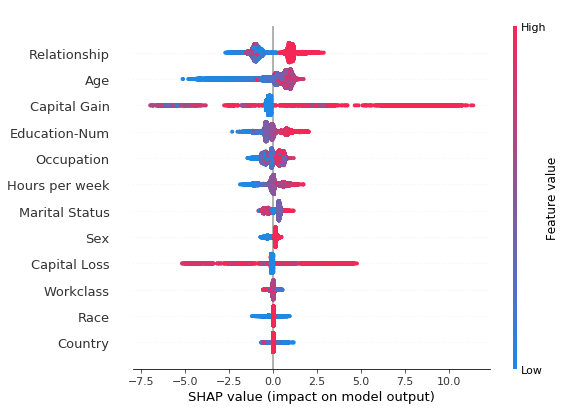

In [61]:
shap.summary_plot(shap_values, X)

## Dependence Plot

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

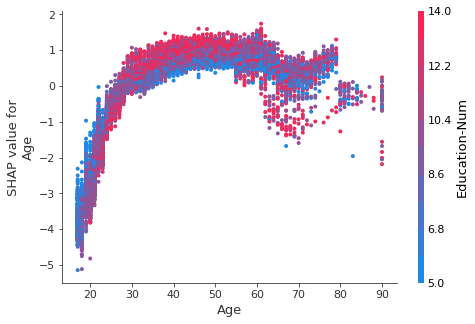

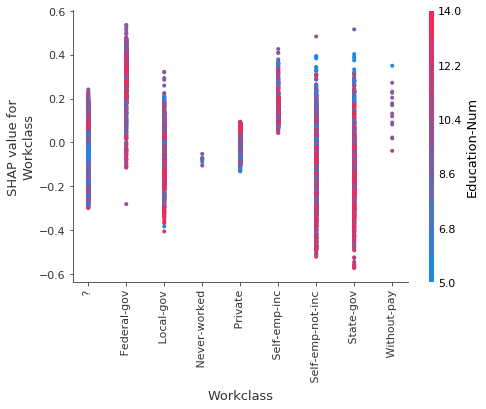

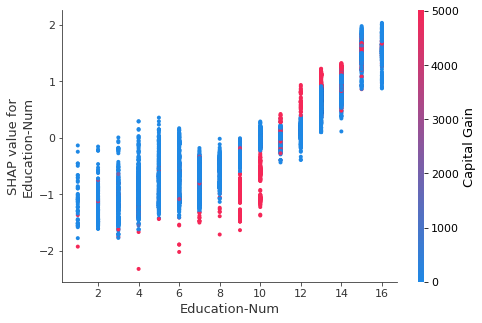

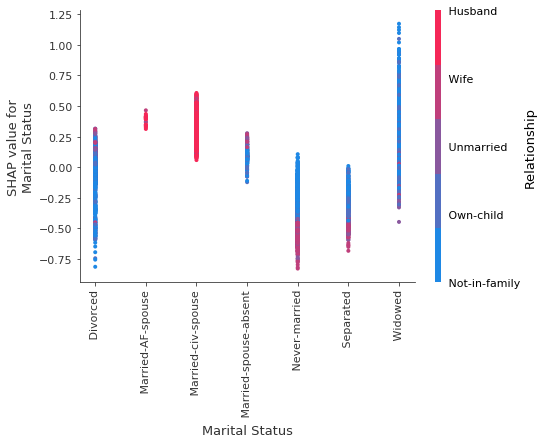

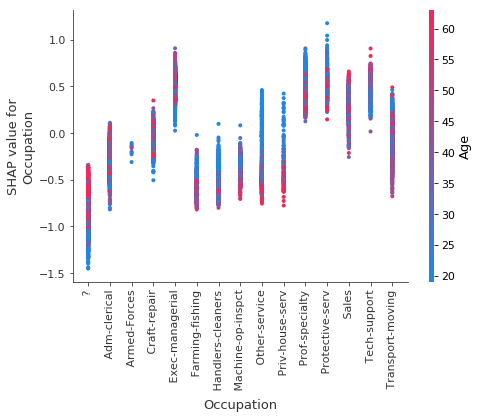

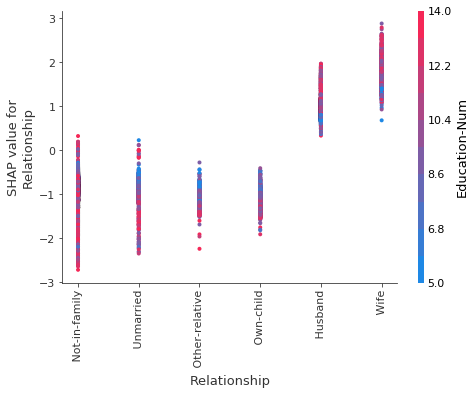

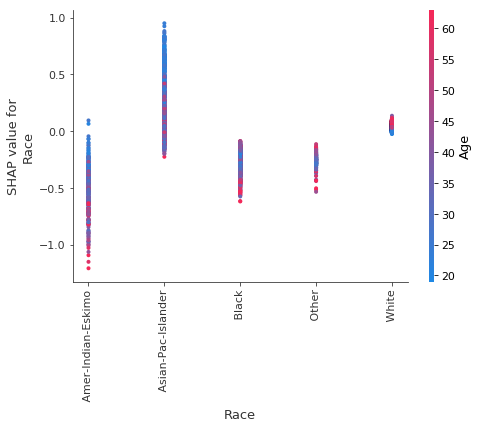

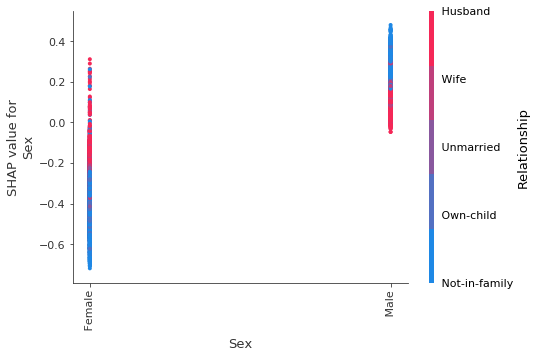

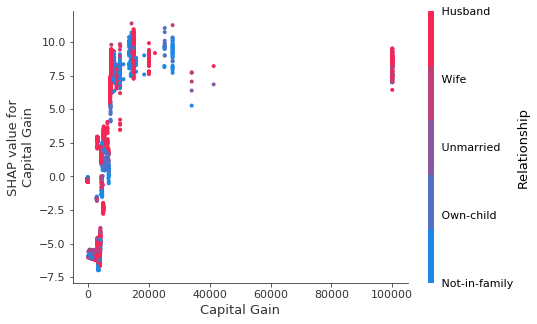

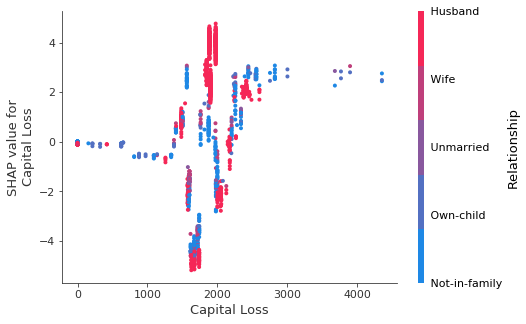

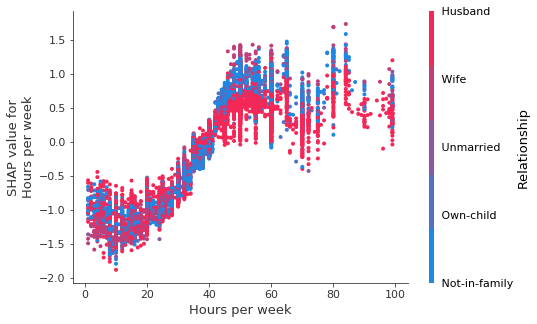

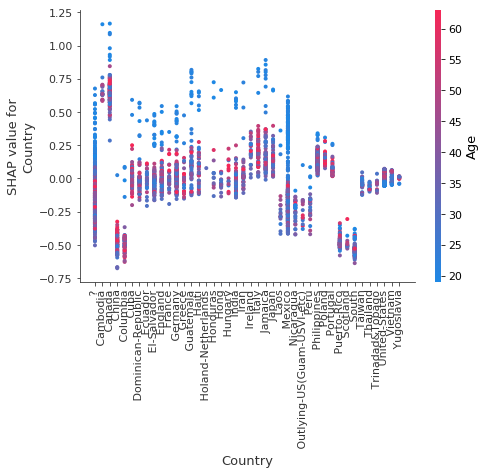

In [66]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

In [63]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [64]:
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
